### UNSUPERVISED MACHINE LEARNING FOR THE CLASSIFICATION OF ASTROPHYSICAL X-RAY SOURCES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score
from sklearn.preprocessing import MinMaxScaler
from astropy import stats
from astropy.io.votable import parse

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 16)
#plt.style.use('ggplot')

In [2]:
votable = parse("./data/corpus.vot")

In [3]:
def votable_to_pandas(votable_file):
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()

In [4]:
data = votable_to_pandas("./data/corpus.vot")

#### Exploración

In [5]:
data.describe()

,obsid,region_id,theta,ra,dec,significance,likelihood,src_area_b,flux_aper_b,hard_hm,...,ks_prob_h,ks_prob_m,ks_prob_s,kp_prob_b,kp_prob_h,kp_prob_m,kp_prob_s,gti_start,gti_stop,gti_elapse
count,37878.000000,37878.000000,37878.000000,37878.000000,37878.000000,37878.000000,3.787800e+04,29752.000000,3.776100e+04,37344.000000,...,33730.000000,35920.000000,3.363000e+04,37420.000000,33730.000000,35920.000000,33630.000000,3.787800e+04,3.787800e+04,37878.000000
mean,7738.962062,383.943080,7.215788,154.484116,-1.713048,44.685588,inf,458.110004,7.113161e-13,0.064582,...,0.607855,0.594805,5.714102e-01,0.627788,0.603570,0.588157,0.565971,2.790502e+08,2.791110e+08,60807.276504
std,4442.685154,840.636764,5.359062,96.174054,38.778529,64.438054,inf,3167.216755,5.771520e-12,0.360548,...,0.318574,0.317466,3.140634e-01,0.325054,0.319590,0.318298,0.313054,1.260029e+08,1.259975e+08,47706.375641
min,19.000000,1.000000,0.004970,0.012318,-85.645638,0.000000,8.097478e+00,0.000037,0.000000e+00,-0.999375,...,0.000035,0.000008,2.968807e-07,0.000023,0.000023,0.000025,0.000002,6.561709e+07,6.566766e+07,948.465970
25%,4181.500000,25.000000,2.778966,83.763094,-29.053841,12.842973,5.664561e+02,0.394041,4.089393e-14,-0.119925,...,0.335645,0.320623,2.962773e-01,0.346806,0.328890,0.309782,0.295771,1.592887e+08,1.594554e+08,27452.799890
50%,7064.000000,96.000000,6.083105,160.982107,-5.355699,21.569519,1.903882e+03,5.090457,9.094241e-14,0.058713,...,0.647459,0.628799,5.966723e-01,0.680281,0.641305,0.623832,0.584503,2.778035e+08,2.778564e+08,48051.200045
75%,11530.000000,312.000000,11.240255,228.306555,33.975893,48.664213,1.084745e+04,55.606112,2.870870e-13,0.227358,...,0.918568,0.900790,8.652320e-01,0.956059,0.918414,0.891419,0.857505,3.852647e+08,3.853960e+08,88428.799680
max,49899.000000,7213.000000,26.922311,359.997656,86.320337,1181.210704,1.797693e+308,143596.278780,5.414790e-10,0.999375,...,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,5.361096e+08,5.361516e+08,192363.182400


In [6]:
data.head()

,name,obsid,region_id,theta,ra,dec,significance,likelihood,src_area_b,flux_aper_b,...,ks_prob_h,ks_prob_m,ks_prob_s,kp_prob_b,kp_prob_h,kp_prob_m,kp_prob_s,gti_start,gti_stop,gti_elapse
0,2CXO J000002.9-350332,15712,4,5.606038,0.012318,-35.059068,16.266113,1506.051665,6.228827,3.589425e-13,...,0.724755,0.317516,0.423297,0.808309,0.669796,0.197852,0.691868,4.989492e+08,4.989593e+08,10068.80008
1,2CXO J000010.0-501526,11997,5,7.662707,0.041803,-50.257400,16.952246,1018.200194,8.978497,3.593006e-14,...,0.249246,0.181138,0.805236,0.614278,0.101385,0.028956,0.918830,3.991763e+08,3.992403e+08,64051.80924
2,2CXO J000019.8-245030,13394,69,14.525021,0.082814,-24.841752,10.720911,351.465473,884.616067,1.002743e-13,...,0.847319,0.495847,0.506963,0.430789,0.817322,0.353208,0.778730,4.294139e+08,4.294639e+08,50055.70038
3,2CXO J000025.4-245419,13394,41,11.145001,0.106246,-24.905300,16.716272,819.212066,39.749528,1.160466e-13,...,0.067084,0.939628,0.368044,0.924866,0.051374,0.950423,0.288221,4.294139e+08,4.294639e+08,50055.70038
4,2CXO J000027.4-500421,11997,43,5.944960,0.114303,-50.072669,26.377284,3525.375052,3.925662,1.093804e-13,...,0.969048,0.227237,0.030124,0.766089,0.932166,0.556750,0.047099,3.991763e+08,3.992403e+08,64051.80924


In [7]:
data.columns

Index(['name', 'obsid', 'region_id', 'theta', 'ra', 'dec', 'significance',
       'likelihood', 'src_area_b', 'flux_aper_b', 'hard_hm', 'hard_hs',
       'hard_ms', 'powlaw_gamma', 'bb_kt', 'var_prob_b', 'var_sigma_b',
       'var_mean_b', 'var_min_b', 'var_max_b', 'var_prob_h', 'var_sigma_h',
       'var_mean_h', 'var_min_h', 'var_max_h', 'var_prob_m', 'var_sigma_m',
       'var_mean_m', 'var_min_m', 'var_max_m', 'var_prob_s', 'var_sigma_s',
       'var_mean_s', 'var_min_s', 'var_max_s', 'ks_prob_b', 'ks_prob_h',
       'ks_prob_m', 'ks_prob_s', 'kp_prob_b', 'kp_prob_h', 'kp_prob_m',
       'kp_prob_s', 'gti_start', 'gti_stop', 'gti_elapse'],
      dtype='object')

In [8]:
print(data.src_area_b.max())
print(data.bb_kt.max())
print(data.powlaw_gamma.max())

143596.27878000482
999.751
10.0


#### K-Means

In [9]:
features_coord = ['ra', 'dec','src_area_b','hard_hm','hard_hs', 'hard_ms', 'var_prob_b', 'var_sigma_b',
            'var_prob_h', 'var_sigma_h',
        'var_prob_m', 'var_sigma_m', 'var_prob_s', 'var_sigma_s', 'ks_prob_b', 'ks_prob_h',
       'ks_prob_m', 'ks_prob_s', 'kp_prob_b', 'kp_prob_h', 'kp_prob_m',
       'kp_prob_s', 'bb_kt']

features = ['src_area_b', 'hard_hm', 'hard_hs', 'hard_ms', 'var_prob_b', 'var_sigma_b',
            'var_prob_h', 'var_sigma_h',
        'var_prob_m', 'var_sigma_m', 'var_prob_s', 'var_sigma_s', 'ks_prob_b', 'ks_prob_h',
       'ks_prob_m', 'ks_prob_s', 'kp_prob_b', 'kp_prob_h', 'kp_prob_m',
       'kp_prob_s', 'bb_kt']

X_df_coord = data[features_coord].dropna()
X_df = X_df_coord[features]
X = X_df.copy().to_numpy()

In [29]:
X_df.min()

src_area_b      4.450494e-05
hard_hm        -9.993754e-01
hard_hs        -9.993754e-01
hard_ms        -8.956902e-01
var_prob_b     3.341805e-234
var_sigma_b     0.000000e+00
var_prob_h     3.921796e-170
var_sigma_h     0.000000e+00
var_prob_m      3.146332e-59
var_sigma_m     0.000000e+00
var_prob_s      5.603721e-85
var_sigma_s     3.469447e-18
ks_prob_b       1.545962e-05
ks_prob_h       3.495976e-05
ks_prob_m       7.600951e-06
ks_prob_s       2.968807e-07
kp_prob_b       2.339507e-05
kp_prob_h       2.309492e-05
kp_prob_m       2.733109e-05
kp_prob_s       2.466219e-06
bb_kt           1.409040e-01
dtype: float64

# _NOTA: Añadir valor mínimo sigma_ 
!= 0

O exp del valor mínimo

### Aplicar logaritmo y luego normalización.

In [11]:
# Log transformation

x = np.log(X_df.src_area_b.values, where = X_df.src_area_b.values >0)  #returns a numpy array
min_max_scaler = MinMaxScaler(feature_range=(0,1))
x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
X[:,0] = x_scaled.flatten()

x = np.log(X_df.var_sigma_b.values, where = X_df.var_sigma_b.values >0)  #returns a numpy array
min_max_scaler = MinMaxScaler(feature_range=(0,1))
x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
X[:,5] = x_scaled.flatten()

x = np.log(X_df.var_sigma_h.values, where = X_df.var_sigma_h.values >0) #returns a numpy array
min_max_scaler = MinMaxScaler(feature_range=(0,1))
x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
X[:,7] = x_scaled.flatten()

x = np.log(X_df.var_sigma_m.values, where = X_df.var_sigma_m.values >0) #returns a numpy array
min_max_scaler = MinMaxScaler(feature_range=(0,1))
x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
X[:,9] = x_scaled.flatten()

x = np.log(X_df.var_sigma_s.values, where = X_df.var_sigma_s.values >0) #returns a numpy array
min_max_scaler = MinMaxScaler(feature_range=(0,1))
x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
X[:,11] = x_scaled.flatten()

x = np.log(X_df.bb_kt.values, where = X_df.var_sigma_s.values >0) #returns a numpy array
min_max_scaler = MinMaxScaler(feature_range=(0,1))
x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
X[:,20] = x_scaled.flatten()


df = pd.DataFrame(X, columns=X_df.columns)
X = df.to_numpy()

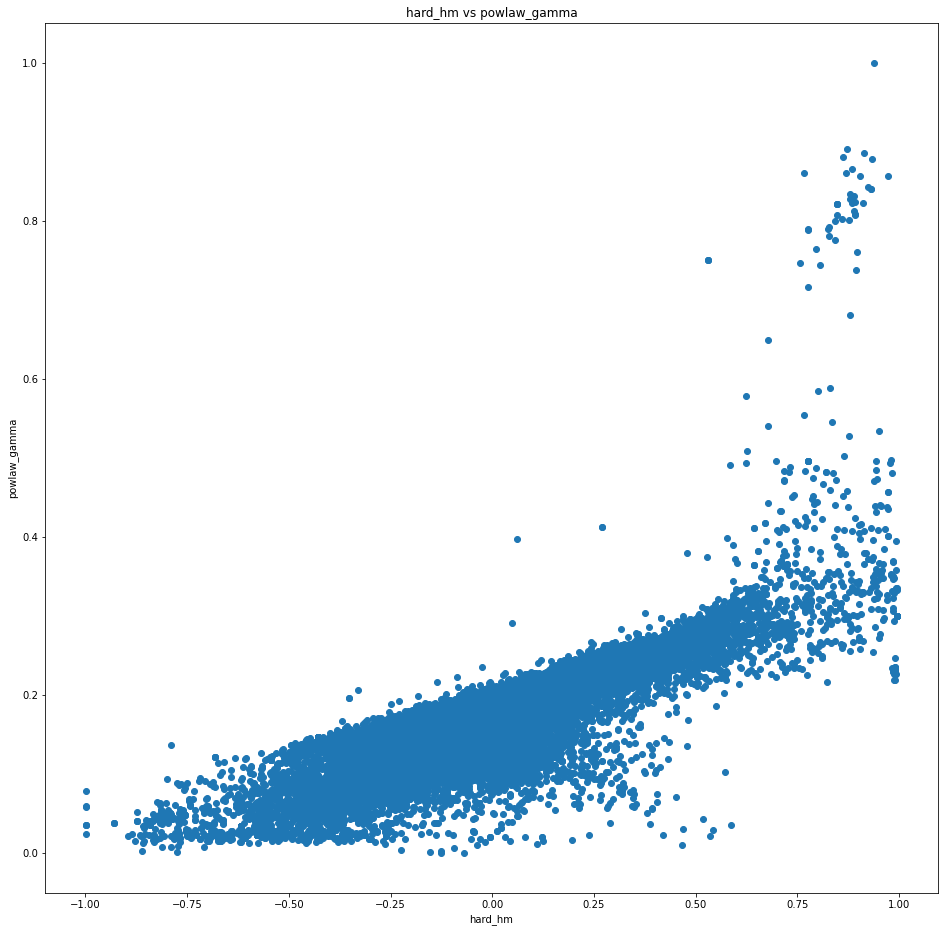

In [13]:
plt.scatter(df.hard_hm,df.bb_kt)
#Labels and Tit
plt.title('hard_hm vs powlaw_gamma')
plt.xlabel('hard_hm')
plt.ylabel('powlaw_gamma')
plt.show()

## NOTA: Hacer tabla con clusters y mandar a Rafael

In [14]:
df.max()

src_area_b     1.000000
hard_hm        0.995628
hard_hs        0.999375
hard_ms        0.999375
var_prob_b     1.000000
var_sigma_b    1.000000
var_prob_h     1.000000
var_sigma_h    1.000000
var_prob_m     1.000000
var_sigma_m    1.000000
var_prob_s     1.000000
var_sigma_s    1.000000
ks_prob_b      1.000000
ks_prob_h      1.000000
ks_prob_m      1.000000
ks_prob_s      1.000000
kp_prob_b      1.000000
kp_prob_h      1.000000
kp_prob_m      1.000000
kp_prob_s      1.000000
bb_kt          1.000000
dtype: float64

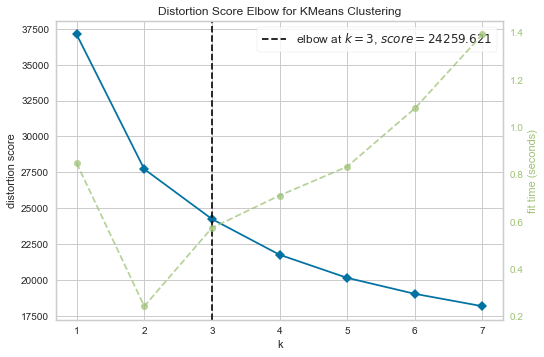

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,8))

# Fit the data to the visualizer
visualizer.fit(df)
visualizer.show()

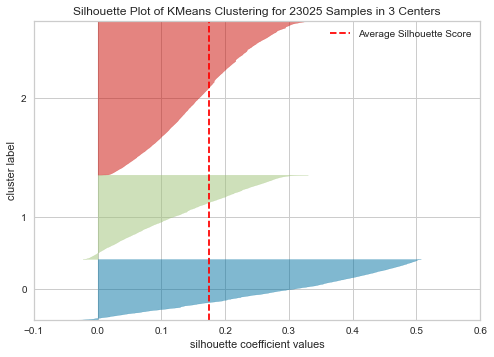

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 23025 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [16]:
kmeans = KMeans(n_clusters=3).fit(df)
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df)
visualizer.show()  

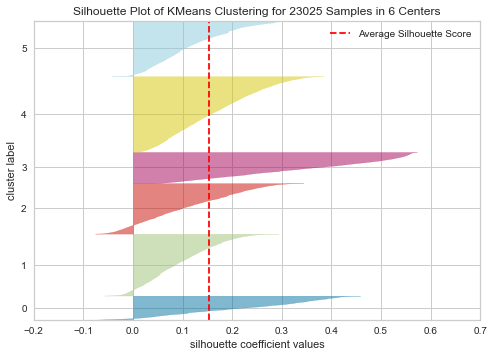

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 23025 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [17]:
kmeans = KMeans(n_clusters=6).fit(df)
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df)
visualizer.show()  

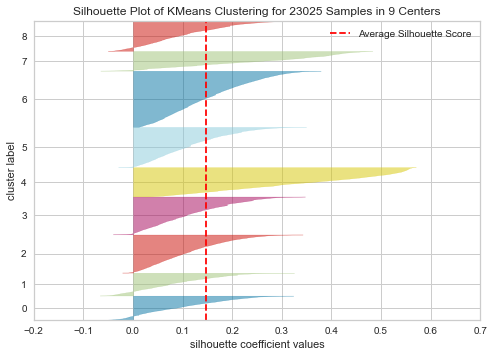

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 23025 Samples in 9 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [18]:
kmeans = KMeans(n_clusters=9).fit(df)
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df)
visualizer.show()  

In [19]:
centroids = kmeans.cluster_centers_
print(centroids)

[[ 0.51438497  0.36121768  0.59439543  0.33200032  0.17153434  0.69416414
   0.23361884  0.5929606   0.22540392  0.57554441  0.37336272  0.58829479
   0.77405183  0.7596899   0.56974586  0.50367341  0.77984866  0.75683425
   0.56705117  0.505322    0.25301664]
 [ 0.53830185 -0.42550672 -0.7602543  -0.518191    0.13977252  0.68311284
   0.37066901  0.5874881   0.22062399  0.57108807  0.17591651  0.58429419
   0.64308077  0.52382299  0.56267774  0.61351891  0.65571248  0.54678755
   0.55837765  0.62121456  0.0728892 ]
 [ 0.53378155  0.05796573 -0.12449886 -0.18331453  0.13565396  0.68132473
   0.31357746  0.59768021  0.17180305  0.56183784  0.33293728  0.59866418
   0.60672236  0.69548459  0.26314385  0.69246254  0.59050259  0.68235145
   0.25311731  0.68586038  0.18157084]
 [ 0.55089114 -0.00399315 -0.211057   -0.21408399  0.20577457  0.69994511
   0.36402305  0.60223473  0.3068835   0.58640304  0.19247673  0.57939738
   0.77320654  0.78243055  0.76184477  0.35953516  0.76259766  0.7737

In [20]:
from matplotlib import colors as mcolors

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
#colors

<IPython.core.display.Javascript object>


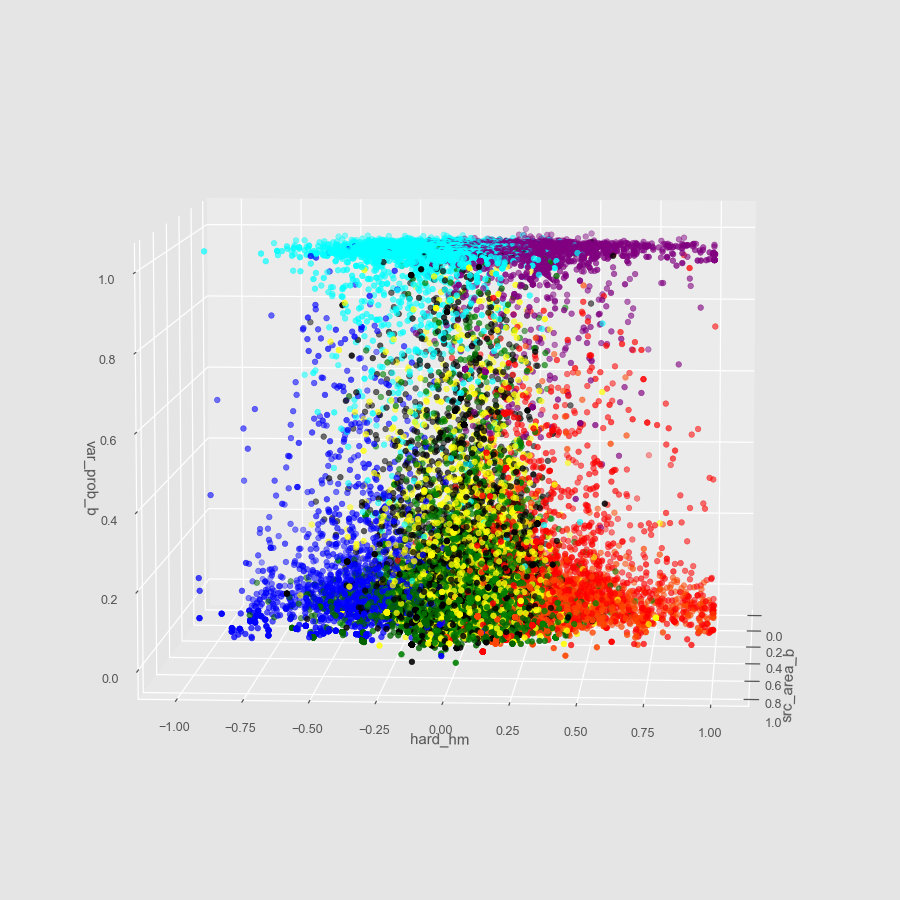

[Text(0.5, 0, 'var_prob_b')]

In [31]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

colx = 0
coly = 1
colz = 4
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','blue', 'green', 'black', 'cyan', 'yellow', 'darkgreen', 'purple', 'orangered']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, colx], X[:, coly], X[:, colz], c=asignar,s=20)
ax.scatter(C[:, colx], C[:, coly], C[:, colz], marker='*', c=colores, s=1000)
ax.set(xlabel = df.columns[colx])
ax.set(ylabel = df.columns[coly])
ax.set(zlabel = df.columns[colz])

In [22]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

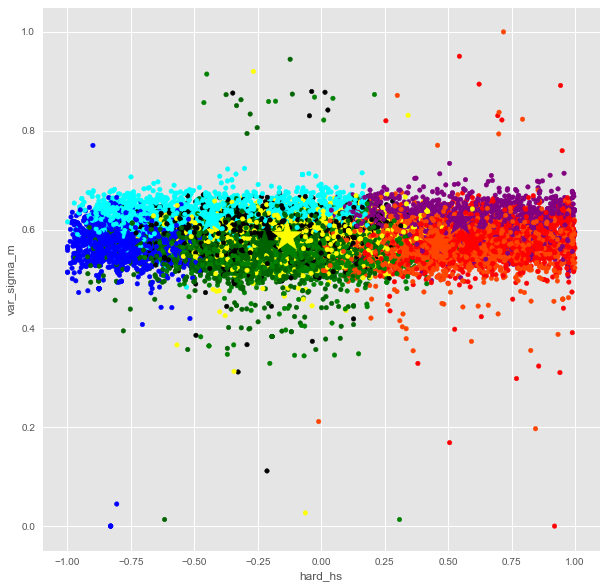

In [23]:
colx = 2
coly = 9
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(df.columns[colx]);
plt.ylabel(df.columns[coly]);

# NOTA: Pairplot con todos.

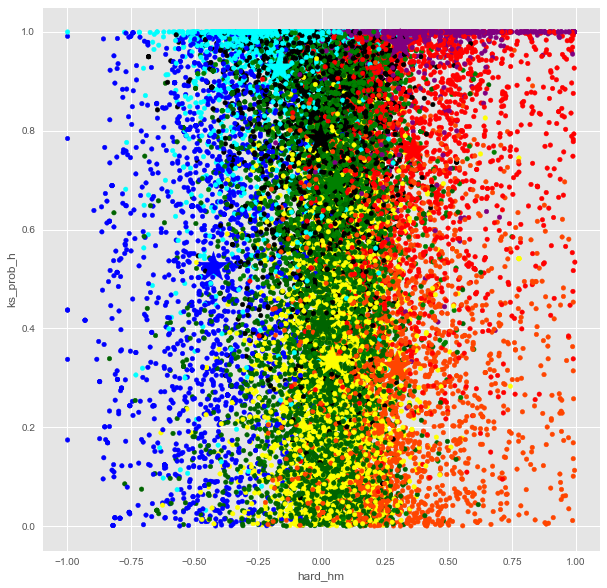

In [24]:
colx = df.columns.get_loc("hard_hm")
coly = df.columns.get_loc("ks_prob_h")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(df.columns[colx]);
plt.ylabel(df.columns[coly]);

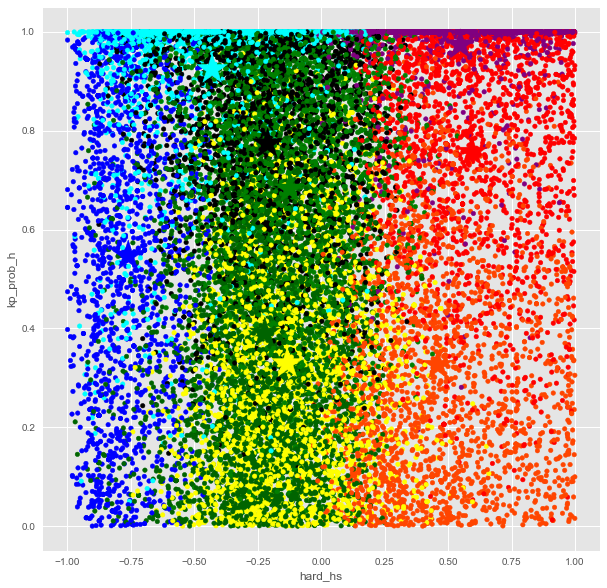

In [25]:
colx = df.columns.get_loc("hard_hs")
coly = df.columns.get_loc("kp_prob_h")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(df.columns[colx]);
plt.ylabel(df.columns[coly]);

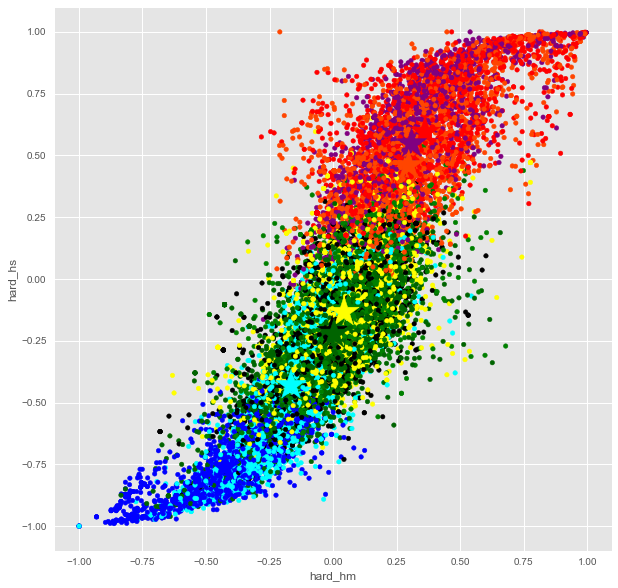

In [26]:
colx = df.columns.get_loc("hard_hm")
coly = df.columns.get_loc("hard_hs")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(df.columns[colx]);
plt.ylabel(df.columns[coly]);

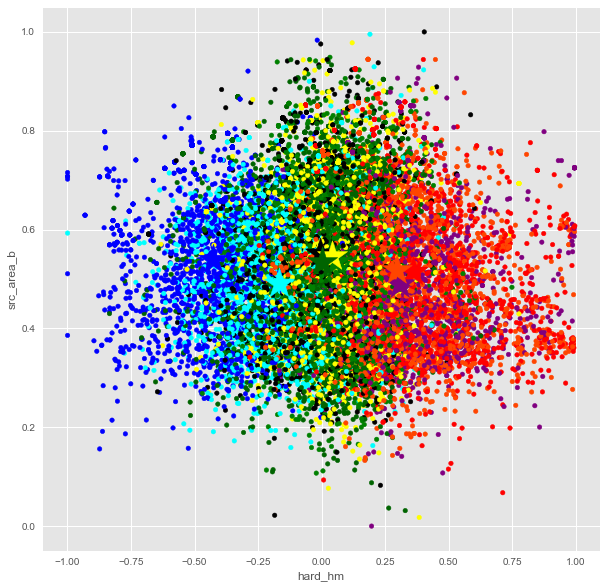

In [27]:
colx = df.columns.get_loc("hard_hm")
coly = df.columns.get_loc("src_area_b")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(df.columns[colx]);
plt.ylabel(df.columns[coly]);

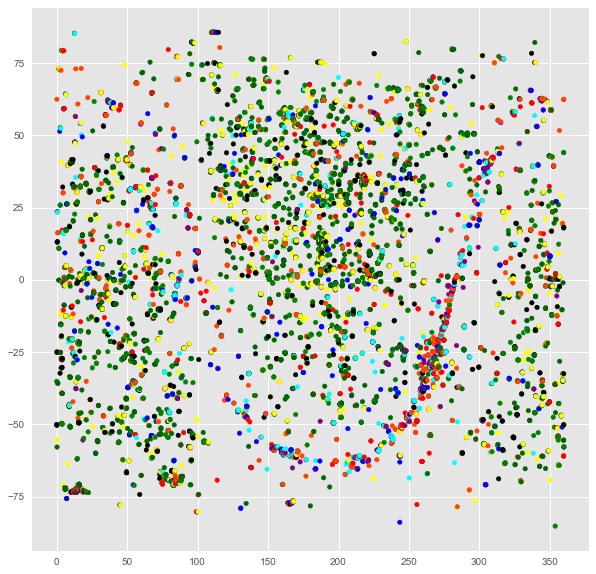

In [28]:
xd=X_df_coord.to_numpy()

fig = plt.figure()
plt.scatter(xd[:, 0], xd[:, 1], c=asignar,s=20)

# _NOTA: Ver objetos en clusters en diferentes herramientas._